In [1]:
#!pip install tflearn

In [2]:
#import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

In [3]:
import os

class Dataset:
    name = 'Fer2013'
    train_folder = 'fer2013_features/Training'
    validation_folder = 'fer2013_features/PublicTest'
    test_folder = 'fer2013_features/PrivateTest'
    shape_predictor_path='shape_predictor_68_face_landmarks.dat'
    trunc_trainset_to = -1  # put the number of train images to use (-1 = all images of the train set)
    trunc_validationset_to = -1
    trunc_testset_to = -1

class Network:
    model = 'B'
    input_size = 48
    output_size = 7
    activation = 'relu'
    loss = 'categorical_crossentropy'
    use_landmarks = True
    use_hog_and_landmarks = True
    use_hog_sliding_window_and_landmarks = True
    use_batchnorm_after_conv_layers = True
    use_batchnorm_after_fully_connected_layers = False

class Hyperparams:
    keep_prob = 0.956   # dropout = 1 - keep_prob
    learning_rate = 0.016
    learning_rate_decay = 0.864
    decay_step = 50
    optimizer = 'momentum'  # {'momentum', 'adam', 'rmsprop', 'adagrad', 'adadelta'}
    optimizer_param = 0.95   # momentum value for Momentum optimizer, or beta1 value for Adam

class Training:
    batch_size = 128
    epochs = 13
    snapshot_step = 500
    vizualize = True
    logs_dir = "logs"
    checkpoint_dir = "checkpoints/chk/"
    best_checkpoint_path = "checkpoints/best/"
    max_checkpoints = 1
    checkpoint_frequency = 1.0 # in hours
    save_model = True
    save_model_path = "best_model/saved_model.bin"

class VideoPredictor:
    emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    print_emotions = False
    camera_source = 0
    face_detection_classifier = "lbpcascade_frontalface.xml"
    show_confidence = False
    time_to_wait_between_predictions = 0.5

class OptimizerSearchSpace:
    learning_rate = {'min': 0.00001, 'max': 0.1}
    learning_rate_decay = {'min': 0.5, 'max': 0.99}
    optimizer = ['momentum']   # ['momentum', 'adam', 'rmsprop', 'adagrad', 'adadelta']
    optimizer_param = {'min': 0.5, 'max': 0.99}
    keep_prob = {'min': 0.7, 'max': 0.99}

def make_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

DATASET = Dataset()
NETWORK = Network()
TRAINING = Training()
HYPERPARAMS = Hyperparams()
VIDEO_PREDICTOR = VideoPredictor()
OPTIMIZER = OptimizerSearchSpace()

make_dir(TRAINING.logs_dir)
make_dir(TRAINING.checkpoint_dir)


from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, add

modelB = Sequential()

modelB.add(Conv2D(64, 3, input_shape=(48,48,1), activation='relu'))
modelB.add(BatchNormalization())

modelB.add(MaxPooling2D((3), strides=2))
modelB.add(Conv2D(128, 3, activation='relu'))
modelB.add(BatchNormalization())

modelB.add(MaxPooling2D((3), strides=2))
modelB.add(Conv2D(256, 3, activation='relu'))
modelB.add(BatchNormalization())

modelB.add(MaxPooling2D((3), strides=2))
modelB.add(Dropout(0.044))
modelB.add(Dense(4096, activation='relu'))

modelB.add(Dropout(0.044))

modelB.add(Dense(1024))
modelB.add(Activation('relu'))
modelB.add(Dense(128, activation='relu'))
modelB.add(BatchNormalization())

#modelL = Sequential()
modelB.add(Dense(1024, input_shape=[None, 2728], activation='relu'))
modelB.add(BatchNormalization())
modelB.add(Dense(128, activation='relu'))
modelB.add(BatchNormalization())

#merged_output = add([modelB.output, modelL.output])   

#modelF = Sequential()
modelB.add(Flatten())
modelB.add(Dense(7))
modelB.add(Activation('softmax'))

#final_model = Model([modelB.input, modelL.input], modelF(merged_output))

In [4]:
#print(modelB.suEmmary())

In [5]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam

In [6]:
import numpy as np

def load_data(validation=False, test=False):
    
    data_dict = dict()
    validation_dict = dict()
    test_dict = dict()

    if DATASET.name == "Fer2013":

        # load train set
        data_dict['X'] = np.load(DATASET.train_folder + '/images.npy')
        data_dict['X'] = data_dict['X'].reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
        if NETWORK.use_landmarks:
            data_dict['X2'] = np.load(DATASET.train_folder + '/landmarks.npy')
        if NETWORK.use_hog_and_landmarks:
            data_dict['X2'] = np.load(DATASET.train_folder + '/landmarks.npy')
            data_dict['X2'] = np.array([x.flatten() for x in data_dict['X2']])
            data_dict['X2'] = np.concatenate((data_dict['X2'], np.load(DATASET.train_folder + '/hog_features.npy')), axis=1)
        data_dict['Y'] = np.load(DATASET.train_folder + '/labels.npy')
        if DATASET.trunc_trainset_to > 0:
            data_dict['X'] = data_dict['X'][0:DATASET.trunc_trainset_to, :, :]
            if NETWORK.use_landmarks and NETWORK.use_hog_and_landmarks:
                data_dict['X2'] = data_dict['X2'][0:DATASET.trunc_trainset_to, :]
            elif NETWORK.use_landmarks:
                data_dict['X2'] = data_dict['X2'][0:DATASET.trunc_trainset_to, :, :]
            data_dict['Y'] = data_dict['Y'][0:DATASET.trunc_trainset_to, :]

        if validation:
            # load validation set
            validation_dict['X'] = np.load(DATASET.validation_folder + '/images.npy')
            validation_dict['X'] = validation_dict['X'].reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
            if NETWORK.use_landmarks:
                validation_dict['X2'] = np.load(DATASET.validation_folder + '/landmarks.npy')
            if NETWORK.use_hog_and_landmarks:
                validation_dict['X2'] = np.load(DATASET.validation_folder + '/landmarks.npy')
                validation_dict['X2'] = np.array([x.flatten() for x in validation_dict['X2']])
                validation_dict['X2'] = np.concatenate((validation_dict['X2'], np.load(DATASET.validation_folder + '/hog_features.npy')), axis=1)
            validation_dict['Y'] = np.load(DATASET.validation_folder + '/labels.npy')
            if DATASET.trunc_validationset_to > 0:
                validation_dict['X'] = validation_dict['X'][0:DATASET.trunc_validationset_to, :, :]
                if NETWORK.use_landmarks and NETWORK.use_hog_and_landmarks:
                    validation_dict['X2'] = validation_dict['X2'][0:DATASET.trunc_validationset_to, :]
                elif NETWORK.use_landmarks:
                    validation_dict['X2'] = validation_dict['X2'][0:DATASET.trunc_validationset_to, :, :]
                validation_dict['Y'] = validation_dict['Y'][0:DATASET.trunc_validationset_to, :]
        
        if test:
            # load test set
            test_dict['X'] = np.load(DATASET.test_folder + '/images.npy')
            test_dict['X'] = test_dict['X'].reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
            if NETWORK.use_landmarks:
                test_dict['X2'] = np.load(DATASET.test_folder + '/landmarks.npy')
            if NETWORK.use_hog_and_landmarks:
                test_dict['X2'] = np.load(DATASET.test_folder + '/landmarks.npy')
                test_dict['X2'] = np.array([x.flatten() for x in test_dict['X2']])
                test_dict['X2'] = np.concatenate((test_dict['X2'], np.load(DATASET.test_folder + '/hog_features.npy')), axis=1)
            test_dict['Y'] = np.load(DATASET.test_folder + '/labels.npy')
            if DATASET.trunc_testset_to > 0:
                test_dict['X'] = test_dict['X'][0:DATASET.trunc_testset_to, :, :]
                if NETWORK.use_landmarks and NETWORK.use_hog_and_landmarks:
                    test_dict['X2'] = test_dict['X2'][0:DATASET.trunc_testset_to, :]
                elif NETWORK.use_landmarks:
                    test_dict['X2'] = test_dict['X2'][0:DATASET.trunc_testset_to, :, :]
                test_dict['Y'] = test_dict['Y'][0:DATASET.trunc_testset_to, :]

        if not validation and not test:
            return data_dict
        elif not test:
            return data_dict, validation_dict
        else: 
            return data_dict, validation_dict, test_dict
    else:
        print( "Unknown dataset")
        exit()

In [7]:
import numpy as np
import pandas as pd
import os
import argparse
import errno
import scipy.misc
import imageio
import dlib
import cv2

from skimage.feature import hog

# initialization
image_height = 48
image_width = 48
window_size = 24
window_step = 6
ONE_HOT_ENCODING = True
SAVE_IMAGES = False
GET_LANDMARKS = True
GET_HOG_FEATURES = True
GET_HOG_IMAGES = False
GET_HOG_WINDOWS_FEATURES = True
SELECTED_LABELS = []
IMAGES_PER_LABEL = 1500
OUTPUT_FOLDER_NAME = "fer2013_features"

if SELECTED_LABELS == []:
    SELECTED_LABELS = [0,1,2,3,4,5,6]
print( str(len(SELECTED_LABELS)) + " expressions")

# loading Dlib predictor and preparing arrays:
print( "preparing")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
original_labels = [0, 1, 2, 3, 4, 5, 6]
new_labels = list(set(original_labels) & set(SELECTED_LABELS))
nb_images_per_label = list(np.zeros(len(new_labels), 'uint8'))
try:
    os.makedirs(OUTPUT_FOLDER_NAME)
except OSError as e:
    if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
        pass
    else:
        raise

def get_landmarks(image, rects):
    # this function have been copied from http://bit.ly/2cj7Fpq
    if len(rects) > 1:
        raise BaseException("TooManyFaces")
    if len(rects) == 0:
        raise BaseException("NoFaces")
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

def get_new_label(label, one_hot_encoding=False):
    if one_hot_encoding:
        new_label = new_labels.index(label)
        label = list(np.zeros(len(new_labels), 'uint8'))
        label[new_label] = 1
        return label
    else:
        return new_labels.index(label)

def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, image_height, window_step):
        for x in range(0, image_width, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualize=False))
    return hog_windows

7 expressions
preparing


print( "importing csv file")
data = pd.read_csv('fer2013.csv')

for category in data['Usage'].unique():
    print( "converting set: " + category + "...")
    # create folder
    if not os.path.exists(category):
        try:
            os.makedirs(OUTPUT_FOLDER_NAME + '/' + category)
        except OSError as e:
            if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
               pass
            else:
                raise
    
    # get samples and labels of the actual category
    category_data = data[data['Usage'] == category]
    samples = category_data['pixels'].values
    labels = category_data['emotion'].values
    
    # get images and extract features
    images = []
    labels_list = []
    landmarks = []
    hog_features = []
    hog_images = []
    for i in range(len(samples)):
        try:
            if labels[i] in SELECTED_LABELS and nb_images_per_label[get_new_label(labels[i])] < IMAGES_PER_LABEL:
                image = np.fromstring(samples[i], dtype=int, sep=" ").reshape((image_height, image_width))
                image = image.astype(np.uint8)
                images.append(image)
                if SAVE_IMAGES:
                    imageio.imsave(category + '/' + str(i) + '.jpg', image)
                if GET_HOG_WINDOWS_FEATURES:
                    features = sliding_hog_windows(image)
                    f, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                            cells_per_block=(1, 1), visualize=True)
                    hog_features.append(features)
                    if GET_HOG_IMAGES:
                        hog_images.append(hog_image)
                elif GET_HOG_FEATURES:
                    features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                            cells_per_block=(1, 1), visualize=True)
                    hog_features.append(features)
                    if GET_HOG_IMAGES:
                        hog_images.append(hog_image)
                if GET_LANDMARKS:
                    imageio.imsave('temp.jpg', image)
                    image2 = cv2.imread('temp.jpg')
                    face_rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
                    face_landmarks = get_landmarks(image2, face_rects)
                    landmarks.append(face_landmarks)            
                labels_list.append(get_new_label(labels[i], one_hot_encoding=ONE_HOT_ENCODING))
                nb_images_per_label[get_new_label(labels[i])] += 1
        except Exception as e:
            print( "error in image: " + str(i) + " - " + str(e))

    np.save(OUTPUT_FOLDER_NAME + '/' + category + '/images.npy', images)
    if ONE_HOT_ENCODING:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/labels.npy', labels_list)
    else:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/labels.npy', labels_list)
    if GET_LANDMARKS:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/landmarks.npy', landmarks)
    if GET_HOG_FEATURES or GET_HOG_WINDOWS_FEATURES:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/hog_features.npy', hog_features)
        if GET_HOG_IMAGES:
            np.save(OUTPUT_FOLDER_NAME + '/' + category + '/hog_images.npy', hog_images)


In [8]:
import tensorflow as tf 
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.merge_ops import merge_outputs, merge
from tflearn.layers.normalization import local_response_normalization, batch_normalization
from tflearn.layers.estimator import regression 
from tflearn.optimizers import Momentum, Adam

def build_model(optimizer=HYPERPARAMS.optimizer, optimizer_param=HYPERPARAMS.optimizer_param, 
    learning_rate=HYPERPARAMS.learning_rate, keep_prob=HYPERPARAMS.keep_prob,
    learning_rate_decay=HYPERPARAMS.learning_rate_decay, decay_step=HYPERPARAMS.decay_step):

    if NETWORK.model == 'A':
        return build_modelA(optimizer, optimizer_param, learning_rate, keep_prob, learning_rate_decay, decay_step)
    elif NETWORK.model == 'B':
        return build_modelB(optimizer, optimizer_param, learning_rate, keep_prob, learning_rate_decay, decay_step)
    else:
        print( "ERROR: no model " + str(NETWORK.model))
        exit()

def build_modelB(optimizer=HYPERPARAMS.optimizer, optimizer_param=HYPERPARAMS.optimizer_param, 
    learning_rate=HYPERPARAMS.learning_rate, keep_prob=HYPERPARAMS.keep_prob,
    learning_rate_decay=HYPERPARAMS.learning_rate_decay, decay_step=HYPERPARAMS.decay_step):

    images_network = input_data(shape=[None, NETWORK.input_size, NETWORK.input_size, 1], name='input1')
    images_network = conv_2d(images_network, 64, 3, activation=NETWORK.activation)
    #images_network = local_response_normalization(images_network)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = conv_2d(images_network, 128, 3, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = conv_2d(images_network, 256, 3, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = dropout(images_network, keep_prob=keep_prob)
    images_network = fully_connected(images_network, 4096, activation=NETWORK.activation)
    images_network = dropout(images_network, keep_prob=keep_prob)
    images_network = fully_connected(images_network, 1024, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_fully_connected_layers:
        images_network = batch_normalization(images_network)

    if NETWORK.use_landmarks or NETWORK.use_hog_and_landmarks:
        if NETWORK.use_hog_sliding_window_and_landmarks:
            landmarks_network = input_data(shape=[None, 2728], name='input2')
        elif NETWORK.use_hog_and_landmarks:
            landmarks_network = input_data(shape=[None, 208], name='input2')
        else:
            landmarks_network = input_data(shape=[None, 68, 2], name='input2')
        landmarks_network = fully_connected(landmarks_network, 1024, activation=NETWORK.activation)
        if NETWORK.use_batchnorm_after_fully_connected_layers:
            landmarks_network = batch_normalization(landmarks_network)
        landmarks_network = fully_connected(landmarks_network, 128, activation=NETWORK.activation)
        if NETWORK.use_batchnorm_after_fully_connected_layers:
            landmarks_network = batch_normalization(landmarks_network)
        images_network = fully_connected(images_network, 128, activation=NETWORK.activation)
        network = merge([images_network, landmarks_network], 'concat', axis=1)
    else:
        network = images_network
    network = fully_connected(network, NETWORK.output_size, activation='softmax')

    if optimizer == 'momentum':
        optimizer = Momentum(learning_rate=learning_rate, momentum=optimizer_param, 
                    lr_decay=learning_rate_decay, decay_step=decay_step)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate, beta1=optimizer_param, beta2=learning_rate_decay)
    else:
        print( "Unknown optimizer: {}".format(optimizer))
    network = regression(network, optimizer=optimizer, loss=NETWORK.loss, learning_rate=learning_rate, name='output')

    return network

def build_modelA(optimizer=HYPERPARAMS.optimizer, optimizer_param=HYPERPARAMS.optimizer_param, 
    learning_rate=HYPERPARAMS.learning_rate, keep_prob=HYPERPARAMS.keep_prob,
    learning_rate_decay=HYPERPARAMS.learning_rate_decay, decay_step=HYPERPARAMS.decay_step):

    images_network = input_data(shape=[None, NETWORK.input_size, NETWORK.input_size, 1], name='input1')
    images_network = conv_2d(images_network, 64, 5, activation=NETWORK.activation)
    #images_network = local_response_normalization(images_network)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = conv_2d(images_network, 64, 5, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = conv_2d(images_network, 128, 4, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = dropout(images_network, keep_prob=keep_prob)
    images_network = fully_connected(images_network, 1024, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_fully_connected_layers:
        images_network = batch_normalization(images_network)

    if NETWORK.use_landmarks or NETWORK.use_hog_and_landmarks:
        if NETWORK.use_hog_sliding_window_and_landmarks:
            landmarks_network = input_data(shape=[None, 2728], name='input2')
        elif NETWORK.use_hog_and_landmarks:
            landmarks_network = input_data(shape=[None, 208], name='input2')
        else:
            landmarks_network = input_data(shape=[None, 68, 2], name='input2')
        landmarks_network = fully_connected(landmarks_network, 1024, activation=NETWORK.activation)
        if NETWORK.use_batchnorm_after_fully_connected_layers:
            landmarks_network = batch_normalization(landmarks_network)
        landmarks_network = fully_connected(landmarks_network, 40, activation=NETWORK.activation)
        if NETWORK.use_batchnorm_after_fully_connected_layers:
            landmarks_network = batch_normalization(landmarks_network)
        images_network = fully_connected(images_network, 40, activation=NETWORK.activation)
        network = merge([images_network, landmarks_network], 'concat', axis=1)
    else:
        network = images_network
    network = fully_connected(network, NETWORK.output_size, activation='softmax')

    if optimizer == 'momentum':
        optimizer = Momentum(learning_rate=learning_rate, momentum=optimizer_param, 
                    lr_decay=learning_rate_decay, decay_step=decay_step)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate, beta1=optimizer_param, beta2=learning_rate_decay)
    else:
        print( "Unknown optimizer: {}".format(optimizer))
    network = regression(network, optimizer=optimizer, loss=NETWORK.loss, learning_rate=learning_rate, name='output')

    return network

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
network.summary()

In [9]:
import tensorflow as tf
from tflearn import DNN
import time
import argparse
import os

def train(optimizer=HYPERPARAMS.optimizer, optimizer_param=HYPERPARAMS.optimizer_param, 
        learning_rate=HYPERPARAMS.learning_rate, keep_prob=HYPERPARAMS.keep_prob, 
        learning_rate_decay=HYPERPARAMS.learning_rate_decay, decay_step=HYPERPARAMS.decay_step,
        train_model=True):

        print( "loading dataset " + DATASET.name + "...")
        if train_model:
                data, validation = load_data(validation=True)
        else:
                data, validation, test = load_data(validation=True, test=True)

        with tf.Graph().as_default():
                print( "building model...")
                network = build_model(optimizer, optimizer_param, learning_rate, 
                          keep_prob, learning_rate_decay, decay_step)
                model = DNN(network, tensorboard_dir=TRAINING.logs_dir, 
                        tensorboard_verbose=0, checkpoint_path=TRAINING.checkpoint_dir,
                        max_checkpoints=TRAINING.max_checkpoints)

                #tflearn.config.init_graph(seed=None, log_device=False, num_cores=6)

                if train_model:
                        # Training phase
                        print( "start training...")
                        print( "  - emotions = {}".format(NETWORK.output_size))
                        print( "  - model = {}".format(NETWORK.model))
                        print( "  - optimizer = '{}'".format(optimizer))
                        print( "  - learning_rate = {}".format(learning_rate))
                        print( "  - learning_rate_decay = {}".format(learning_rate_decay))
                        print( "  - otimizer_param ({}) = {}".format('beta1' if optimizer == 'adam' else 'momentum', optimizer_param))
                        print( "  - keep_prob = {}".format(keep_prob))
                        print( "  - epochs = {}".format(TRAINING.epochs))
                        print( "  - use landmarks = {}".format(NETWORK.use_landmarks))
                        print( "  - use hog + landmarks = {}".format(NETWORK.use_hog_and_landmarks))
                        print( "  - use hog sliding window + landmarks = {}".format(NETWORK.use_hog_sliding_window_and_landmarks))
                        print( "  - use batchnorm after conv = {}".format(NETWORK.use_batchnorm_after_conv_layers))
                        print( "  - use batchnorm after fc = {}".format(NETWORK.use_batchnorm_after_fully_connected_layers))

                        start_time = time.time()
                        if NETWORK.use_landmarks:
                                history=model.fit([data['X'], data['X2']], data['Y'],
                                        validation_set=([validation['X'], validation['X2']], validation['Y']),
                                        snapshot_step=TRAINING.snapshot_step,
                                        show_metric=TRAINING.vizualize,
                                        batch_size=TRAINING.batch_size,
                                        n_epoch=TRAINING.epochs)
                        else:
                                history=model.fit(data['X'], data['Y'],
                                        validation_set=(validation['X'], validation['Y']),
                                        snapshot_step=TRAINING.snapshot_step,
                                        show_metric=TRAINING.vizualize,
                                        batch_size=TRAINING.batch_size,
                                        n_epoch=TRAINING.epochs)
                                validation['X2'] = None
                        training_time = time.time() - start_time
                        print( "training time = {0:.1f} sec".format(training_time))

                        if TRAINING.save_model:
                                print( "saving model...")
                                model.save(TRAINING.save_model_path)
                                if not(os.path.isfile(TRAINING.save_model_path)) and \
                                        os.path.isfile(TRAINING.save_model_path + ".meta"):
                                        os.rename(TRAINING.save_model_path + ".meta", TRAINING.save_model_path)

                        print( "evaluating...")
                        validation_accuracy = evaluate(model, validation['X'], validation['X2'], validation['Y'])
                        print( "  - validation accuracy = {0:.1f}".format(validation_accuracy*100))
                        return data['X'], data['X2'], data['Y'], validation['X'], validation['X2'], validation['Y'], validation_accuracy
                else:
                        # Testing phase : load saved model and evaluate on test dataset
                        print( "start evaluation...")
                        print( "loading pretrained model...")
                        if os.path.isfile(TRAINING.save_model_path):
                                model.load(TRAINING.save_model_path)
                        else:
                                print( "Error: file '{}' not found".format(TRAINING.save_model_path))
                                exit()
                        
                        if not NETWORK.use_landmarks:
                                validation['X2'] = None
                                test['X2'] = None

                        print( "--")
                        print( "Validation samples: {}".format(len(validation['Y'])))
                        print( "Test samples: {}".format(len(test['Y'])))
                        print( "--")
                        print( "evaluating...")
                        start_time = time.time()
                        validation_accuracy = evaluate(model, validation['X'], validation['X2'], validation['Y'])
                        print( "  - validation accuracy = {0:.1f}".format(validation_accuracy*100))
                        test_accuracy = evaluate(model, test['X'], test['X2'], test['Y'])
                        print( "  - test accuracy = {0:.1f}".format(test_accuracy*100))
                        print( "  - evalution time = {0:.1f} sec".format(time.time() - start_time))
                        return test['X'], test['X2'], test['Y'], test_accuracy 

def evaluate(model, X, X2, Y):
        if NETWORK.use_landmarks:
                accuracy = model.evaluate([X, X2], Y)
        else:
                accuracy = model.evaluate(X, Y)
        return accuracy[0]

In [10]:
data_x, data_x2, data_y, val_x, val_x2, val_y, val_acc = train()

Training Step: 2924  | total loss: 0.43436 | time: 13.809s
| Momentum | epoch: 013 | loss: 0.43436 - acc: 0.8717 -- iter: 28672/28709
Training Step: 2925  | total loss: 0.42458 | time: 14.876s
| Momentum | epoch: 013 | loss: 0.42458 - acc: 0.8743 | val_loss: 1.27180 - val_acc: 0.6035 -- iter: 28709/28709
--
training time = 265.3 sec
saving model...
evaluating...
  - validation accuracy = 60.4


In [11]:
test_X, test_X2, test_Y, test_acc = train(train_model=False)

loading dataset Fer2013...
building model...
start evaluation...
loading pretrained model...
INFO:tensorflow:Restoring parameters from /notebooks/best_model/saved_model.bin
--
Validation samples: 3589
Test samples: 3589
--
evaluating...
  - validation accuracy = 60.4
  - test accuracy = 62.1
  - evalution time = 2.0 sec


In [13]:
import tensorflow as tf
from tflearn import DNN
import time
import numpy as np
import argparse
import dlib
import cv2
import os
from skimage.feature import hog

window_size = 24
window_step = 6

def load_model():
    model = None
    with tf.Graph().as_default():
        print( "loading pretrained model...")
        network = build_model()
        model = DNN(network)
        if os.path.isfile(TRAINING.save_model_path):
            model.load(TRAINING.save_model_path)
        else:
            print( "Error: file '{}' not found".format(TRAINING.save_model_path))
    return model

def get_landmarks(image, rects, predictor):
    # this function have been copied from http://bit.ly/2cj7Fpq
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, NETWORK.input_size, window_step):
        for x in range(0, NETWORK.input_size, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualize=False))
    return hog_windows

def predict(image, model, shape_predictor=None):
    # get landmarks
    if NETWORK.use_landmarks or NETWORK.use_hog_and_landmarks or NETWORK.use_hog_sliding_window_and_landmarks:
        face_rects = [dlib.rectangle(left=0, top=0, right=NETWORK.input_size, bottom=NETWORK.input_size)]
        face_landmarks = np.array([get_landmarks(image, face_rects, shape_predictor)])
        features = face_landmarks
        if NETWORK.use_hog_sliding_window_and_landmarks: 
            hog_features = sliding_hog_windows(image)
            hog_features = np.asarray(hog_features)
            face_landmarks = face_landmarks.flatten()
            features = np.concatenate((face_landmarks, hog_features))
        else:
            hog_features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                    cells_per_block=(1, 1), visualize=True)
            hog_features = np.asarray(hog_features)
            face_landmarks = face_landmarks.flatten()
            features = np.concatenate((face_landmarks, hog_features))
        tensor_image = image.reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
        predicted_label = model.predict([tensor_image, features.reshape((1, -1))])
        return get_emotion(predicted_label[0])
    else:
        tensor_image = image.reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
        predicted_label = model.predict(tensor_image)
        return get_emotion(predicted_label[0])
    return None

def get_emotion(label):
    if VIDEO_PREDICTOR.print_emotions:
        print( "- Angry: {0:.1f}%\n- Happy: {1:.1f}%\n- Sad: {2:.1f}%\n- Surprise: {3:.1f}%\n- Neutral: {4:.1f}%".format(
                label[0]*100, label[1]*100, label[2]*100, label[3]*100, label[4]*100))
    label = label.tolist()
    return VIDEO_PREDICTOR.emotions[label.index(max(label))], max(label)

# parse arg to see if we need to launch training now or not yet
if False:
    if True:
        model = load_model()
        image = cv2.imread('PublicTest\803.jpg', 0)
        shape_predictor = dlib.shape_predictor(DATASET.shape_predictor_path)
        start_time = time.time()
        emotion, confidence = predict(image, model, shape_predictor)
        total_time = time.time() - start_time
        print( "Prediction: {0} (confidence: {1:.1f}%)".format(emotion, confidence*100))
        print( "time: {0:.1f} sec".format(total_time))
    else:
        print( "Error: file '{}' not found".format('Not found'))

In [14]:
from skimage.io import imread, imshow

In [15]:
Y_test=np.argmax(test_Y, axis=1)

In [18]:
del val_x, val_x2, val_y, val_acc

In [20]:
Y_predict = model.predict([test_X, test_X2])

In [21]:
Y_Pred = np.argmax(Y_predict, axis=1)

Confusion Matrix
[[267   4  52  28  82   6  52]
 [ 12  28   6   2   4   1   2]
 [ 71   2 243  22  97  40  53]
 [ 27   1  30 722  37  10  52]
 [ 61   1  85  46 298   8  95]
 [ 11   1  51  30   7 299  17]
 [ 62   2  37  45  98   9 373]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       491
           1       0.72      0.51      0.60        55
           2       0.48      0.46      0.47       528
           3       0.81      0.82      0.81       879
           4       0.48      0.50      0.49       594
           5       0.80      0.72      0.76       416
           6       0.58      0.60      0.59       626

    accuracy                           0.62      3589
   macro avg       0.63      0.59      0.61      3589
weighted avg       0.62      0.62      0.62      3589



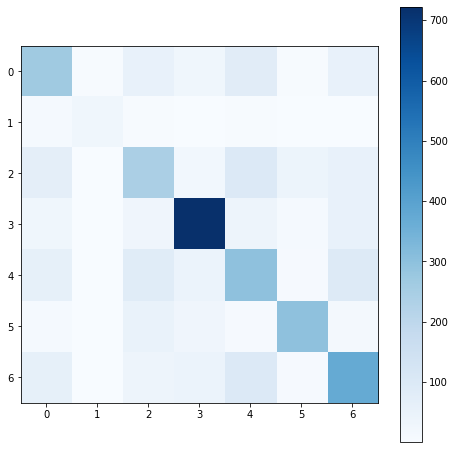

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
cm_test = confusion_matrix(Y_test, Y_Pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
print(classification_report(Y_test, Y_Pred))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

In [32]:
def plot_confusion_matrix(y_set, y_pred,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_set, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)

    plt.rcParams["figure.figsize"] = (8,8)        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

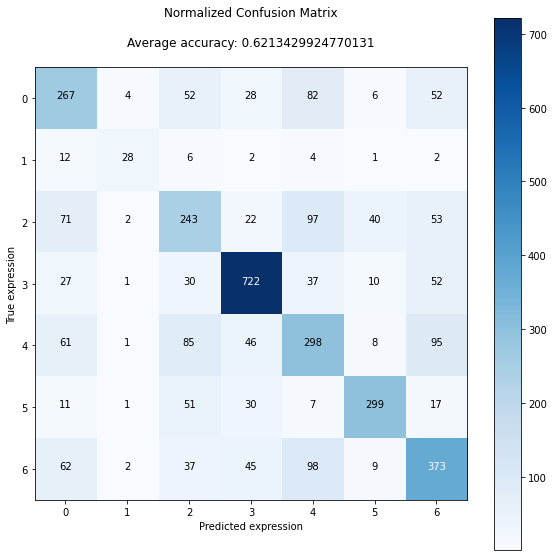

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
fig = plot_confusion_matrix(y_set=Y_test, y_pred=Y_Pred,
                      normalize=False,
                      cmap=plt.cm.Blues,
                      title='Confusion Matrix'+'\n\n'+'Average accuracy: ' + str(np.sum(Y_Pred == Y_test)/len(Y_test)) + '\n')

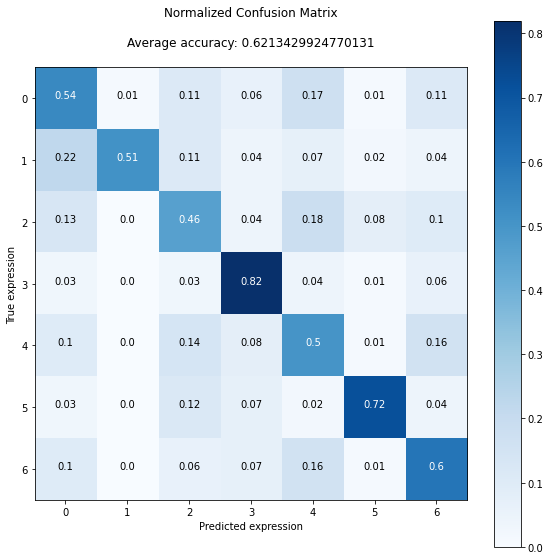

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
fig = plot_confusion_matrix(y_set=Y_test, y_pred=Y_Pred,
                      normalize=True,
                      cmap=plt.cm.Blues,
                      title='Normalized Confusion Matrix'+'\n\n'+'Average accuracy: ' + str(np.sum(Y_Pred == Y_test)/len(Y_test)) + '\n')